# Jax Linear Model for Classification
- Closed-form
- Regularization $L_2$
- **Adults** Dataset Case Study

<a href="http://colab.research.google.com/github/Ivanrs297/machine-learning-projects/blob/main/MariaDB-ML/3_Jax_linear_model/jax_linear_models.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=22.5></a> 

In [1]:
# !pip install jax_metrics

In [2]:
# !pip install --upgrade pip
# !pip install --upgrade "jax[cpu]"

In [2]:
import jax
import jax_metrics as jm
import jax.numpy as jnp
from jax import grad, jit, vmap
from functools import partial
from jax import random
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Linear_Model():
    """
    Basic Linear Regression with Ridge Regression
    """
    def __init__(self, dim: int) -> None:
        self.dim = dim
        self.key = jax.random.PRNGKey(0)
        self.cpus = jax.devices("cpu")
    
    # The classic one
    def generate_canonical_estimator(self, X: jnp, y:jnp) -> jnp:
        """
        Cannonical LSE error solution for the Linearly separable classes 
        args:
            X: Data array at the GPU or CPU
            y: Label array at the GPU 
        returns:
            w: Weight array at the GPU or CPU
        """
        return  jax.numpy.linalg.inv(jax.numpy.transpose(X)@X)@jax.numpy.transpose(X)@y
    
    @staticmethod
    @jit
    def linear_model(X: jnp, theta: jnp) -> jnp:
        """
        Classic Linear Model. Jit has been used to accelerate the loops after the first one
        for the Gradient Descent part
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
        returns:
            f(x): the escalar estimation on vector x or the array of estimations
        """
        w = theta[:-1]
        b = theta[-1]
        return jax.numpy.matmul(X, w) + b
    
    @partial(jit, static_argnums=(0,))
    def LSE(self, theta: jnp, X: jnp, y: jnp)-> jnp:
        """
        LSE in matrix form. We also use Jit por froze info at self to follow 
        the idea of functional programming on Jit for no side effects
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
            y: array of labels
        returns:
            the Loss function LSE under data X, labels y and theta initial estimation
        """
        return (jax.numpy.transpose(y - self.linear_model(X, theta))@(y - self.linear_model(X, theta)))[0,0]
    
    @partial(jit, static_argnums=(0,))
    def update(self, theta: jnp, X: jnp, y: jnp, lr):
        """
        Update makes use of the autograd at Jax to calculate the gradient descent.
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
            y: array of labels
            lr: Learning rate for Gradient Descent
        returns:
            the step update w(n+1) = w(n)-δ(t)𝜵L(w(n))        
        """
        return theta - lr * jax.grad(self.LSE)(theta, X, y)  

    def generate_w_aug(self):
        """
        Use the random generator at Jax to generate a random generator to instanciate
        the augmented values
        """
        keys = random.split(self.key, 1)
        return jax.numpy.vstack([random.normal(keys, (self.dim,1)), jax.numpy.array(1)])
    
    def generate_theta(self):
        """
        Use the random generator at Jax to generate a random generator to instanciate
        the augmented values
        """
        keys = random.split(self.key, 1)
        return jax.numpy.vstack([random.normal(keys, (self.dim,1)), jax.numpy.array(0)])
    
    @partial(jit, static_argnums=(0,))
    def estimate_grsl(self, X, theta):
        """
        Estimation for the Gradient Descent version
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
        return:
            Estimation of data X under linear model
        """
        w = theta[:-1]
        b = theta[-1]
        return X@w+b
    
    @staticmethod
    def estimate_cannonical(X: jnp, w: jnp)->jnp:
        """
        Estimation for the Gradient Descent version
        args:
            X: Data array at the GPU or CPU
            w: Parameter w under extended space
        return:
            Estimation of data X under cannonical solution
        """
        return X@w
    
    def precision(self, y, y_hat):
        """
        Precision
        args:
            y: Real Labels
            y_hat: estimated labels
        return TP/(TP+FP)
        """
        TP = sum(y_hat[y>0]>0)
        FP = sum(y_hat[y>0]<0)
        precision_cpu = jax.jit(lambda x: x, device=self.cpus[0])(TP/(TP+FP))
        return float(precision_cpu)
    
    def gradient_descent(self, theta: jnp,  X: jnp, y: jnp, n_steps: int, lr = 0.001):
        """
        Gradient Descent Loop for the LSE Linear Model
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
            y: array of labels
            n_steps: number steps for the Gradient Loop
            lr: Learning rate for Gradient Descent   
        return:
            Updated Theta
        """
        for i in range(n_steps):
            theta = self.update(theta, X, y, lr)
        return theta
         

## Generate Data

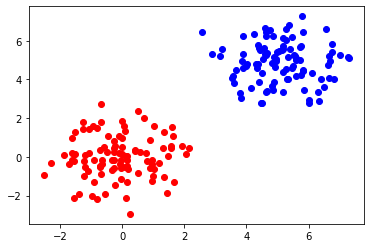

In [4]:
X1 = np.random.normal(size=(100,2))
X2 = np.random.normal(size=(100,2))+(5,5)

plt.figure()
plt.plot(X1[:,0], X1[:,1], 'ro')
plt.plot(X2[:,0], X2[:,1], 'bo')

## Preprocessing for Cannonical version
Data Augmentation is applied for the Cannonical version

In [5]:
X1_e = np.hstack([X1, np.ones((100,1))])
X2_e = np.hstack([X2, np.ones((100,1))])
X_e = np.vstack([X1_e, X2_e])
X = np.vstack([X1, X2])
y = np.vstack([-np.ones((100, 1)), np.ones((100, 1))])

In [6]:
X_e.shape, y.shape

((200, 3), (200, 1))

## Model

In [7]:
dim = 2
model = Linear_Model(dim)
model

In [8]:
w = model.generate_canonical_estimator(X_e, y)
w

DeviceArray([[ 0.19595921],
             [ 0.16862613],
             [-0.89800334]], dtype=float32)

## Prediction

In [9]:
y_hat = model.estimate_cannonical(X_e, w)
print(model.precision(y, y_hat))

1.0


# Homework

In [10]:
theta = model.generate_theta()
theta

DeviceArray([[1.4321449],
             [1.3629805],
             [0.       ]], dtype=float32)

In [11]:
theta = model.gradient_descent(theta, X, y, 100, lr = 0.0001)
theta

DeviceArray([[ 0.19162394],
             [ 0.15752025],
             [-0.81897384]], dtype=float32)

In [12]:
y_hat = model.estimate_grsl(X, theta)
print(model.precision(y, y_hat))

1.0


## Golden Ratio Learning Rate

From [Lecture Slides]("https://github.com/kajuna0amendez/Class_MachineLearning_Jax/blob/main/Notes_Extra_Material/Notes_Golden_Ratio.pdf")

$$
\varphi  = \frac{1+\sqrt{5}}{2} = 1.618033988...
$$

In [13]:
g_ratio = 1.618033
model = Linear_Model(dim)
theta = model.generate_theta()
theta = model.gradient_descent(theta, X, y, 100, lr = g_ratio)
theta

DeviceArray([[nan],
             [nan],
             [nan]], dtype=float32)

In [14]:
y_hat = model.estimate_grsl(X, theta)
print(model.precision(y, y_hat))

nan


$$
\varphi  = \frac{-1+\sqrt{5}}{2} = 1.618033988...
$$

In [15]:
g_ratio = 0.6180
model = Linear_Model(dim)
theta = model.generate_theta()
theta = model.gradient_descent(theta, X, y, 100, lr = g_ratio)
theta

DeviceArray([[nan],
             [nan],
             [nan]], dtype=float32)

In [16]:
y_hat = model.estimate_grsl(X, theta)
print(model.precision(y, y_hat))

nan


## Bisection Learning Rate
Successively halves the bracketing interval (binary search)

In [17]:
class Bisection_Linear_Model(Linear_Model):
  def __init__(self, dim):
    super().__init__(dim)

  def bisection_gradient_descent(self, theta: jnp,  X: jnp, y: jnp, n_steps: int, a, b):
    for i in range(n_steps):
      c = a + b / 2
      theta = self.update(theta, X, y, c)
      b = c
      print(f"lr: {c}")
    return theta

In [18]:
# interval for bisection
a, b = 0, 0.01

model = Bisection_Linear_Model(dim)
theta = model.generate_theta()

In [19]:
theta = model.bisection_gradient_descent(theta, X, y, 10, a, b)
theta

lr: 0.005
lr: 0.0025
lr: 0.00125
lr: 0.000625
lr: 0.0003125
lr: 0.00015625
lr: 7.8125e-05
lr: 3.90625e-05
lr: 1.953125e-05
lr: 9.765625e-06


DeviceArray([[12801.939 ],
             [12349.876 ],
             [ 2436.8342]], dtype=float32)

In [20]:
y_hat = model.estimate_grsl(X, theta)
print(model.precision(y, y_hat))

1.0


## Regularized Version - Ridge Regression
$L_2$ Norm

$$
\theta = (X^TX+A)^-1(X^Ty)
$$

In [21]:
class Regularized_Linear_Model(Linear_Model):
  def __init__(self, dim, alpha):
    self.alpha = alpha
    super().__init__(dim)

  # Ridge Regression
  def generate_canonical__regularized_estimator(self, X: jnp, y:jnp) -> jnp:
    
    # number of columns in matrix of X including intercept
    dimension = X.shape[1]

    # Identity matrix of dimension compatible with our X Matrix
    A = np.identity(dimension)

    # set first 1 on the diagonal to zero so as not to include a bias term for
    # the intercept
    A[0, 0] = 0

    # We create a bias term corresponding to alpha for each column of X not
    # including the intercept
    X_biased = self.alpha * A
    
    return  jax.numpy.linalg.inv(jax.numpy.transpose(X)@X + X_biased)@jax.numpy.transpose(X)@y

In [22]:
X_e.shape[1]

3

In [23]:
alpha = 1
model = Regularized_Linear_Model(dim, alpha)
w = model.generate_canonical__regularized_estimator(X_e, y)
w

DeviceArray([[ 0.19572568],
             [ 0.16718003],
             [-0.88944316]], dtype=float32)

In [24]:
y_hat = model.estimate_cannonical(X_e, w)
print(model.precision(y, y_hat))

1.0


## GridSearch for Alpha

In [25]:
class Recall_Regularized_Linear_Model(Regularized_Linear_Model):
  def __init__(self, dim, alpha):
    super().__init__(dim, alpha)
  
  def recall(self, y, y_hat):
    """
    Recall
    args:
        y: Real Labels
        y_hat: estimated labels
    return TP/(TP+FN)
    """
    TP = sum(y_hat[y>0]>0)
    FN = sum(y_hat[y<0]>0)

    recall_cpu = jax.jit(lambda x: x, device=self.cpus[0])(TP/(TP+FN))
    return float(recall_cpu)

In [26]:
alphas = [0, 0.5, 1, 1.5, 2, 2.5]

for alpha in alphas:
    model = Recall_Regularized_Linear_Model(dim, alpha)
    w = model.generate_canonical__regularized_estimator(X_e, y)
    y_hat = model.estimate_cannonical(X_e, w)
    print(f"Alpha: {alpha}, \tPrecision: {model.precision(y, y_hat)} \tRecall: {model.recall(y, y_hat)}")

Alpha: 0, 	Precision: 1.0 	Recall: 1.0
Alpha: 0.5, 	Precision: 1.0 	Recall: 1.0
Alpha: 1, 	Precision: 1.0 	Recall: 1.0
Alpha: 1.5, 	Precision: 1.0 	Recall: 1.0
Alpha: 2, 	Precision: 1.0 	Recall: 1.0
Alpha: 2.5, 	Precision: 1.0 	Recall: 1.0


# Adult Dataset

## Preproccesing

In [27]:
import pandas as pd

url = "https://www.openml.org/data/download/1595261/phpMawTba"

df = pd.read_csv(url, header = None, skiprows=19,na_values=' ?')
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [28]:
df.describe()

,0,2,4,10,11,12
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       48842 non-null  int64 
 1   1       46043 non-null  object
 2   2       48842 non-null  int64 
 3   3       48842 non-null  object
 4   4       48842 non-null  int64 
 5   5       48842 non-null  object
 6   6       46033 non-null  object
 7   7       48842 non-null  object
 8   8       48842 non-null  object
 9   9       48842 non-null  object
 10  10      48842 non-null  int64 
 11  11      48842 non-null  int64 
 12  12      48842 non-null  int64 
 13  13      47985 non-null  object
 14  14      48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [30]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df[14] = le.fit_transform(df[14])
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,0


In [31]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       45222 non-null  int64 
 1   1       45222 non-null  object
 2   2       45222 non-null  int64 
 3   3       45222 non-null  object
 4   4       45222 non-null  int64 
 5   5       45222 non-null  object
 6   6       45222 non-null  object
 7   7       45222 non-null  object
 8   8       45222 non-null  object
 9   9       45222 non-null  object
 10  10      45222 non-null  int64 
 11  11      45222 non-null  int64 
 12  12      45222 non-null  int64 
 13  13      45222 non-null  object
 14  14      45222 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.5+ MB


In [32]:
df = pd.get_dummies(df)

In [33]:
df.head()

,0,2,4,10,11,12,14,1_ Federal-gov,1_ Local-gov,1_ Private,...,13_ Portugal,13_ Puerto-Rico,13_ Scotland,13_ South,13_ Taiwan,13_ Thailand,13_ Trinadad&Tobago,13_ United-States,13_ Vietnam,13_ Yugoslavia
0,25,226802,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,38,89814,9,0,0,50,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,28,336951,12,0,0,40,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,44,160323,10,7688,0,40,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
5,34,198693,6,0,0,30,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [34]:
y = df[14].values
X = df.drop([14], axis = 1).values

In [35]:
X.shape, y.shape

((45222, 104), (45222,))

## Model

In [36]:
class Final_Model(Recall_Regularized_Linear_Model):
  def __init__(self, dim, alpha):
    super().__init__(dim, alpha)
  
  def accuracy(self, y, y_hat):
    """
    Accuracy
    args:
        y: Real Labels
        y_hat: estimated labels
    return TP+TN/(TP+FP+FN+TN)
    """
    TP = sum(y_hat[y>0]>0)
    TN = sum(y_hat[y<0]<0)

    FN = sum(y_hat[y<0]>0)
    FP = sum(y_hat[y>0]<0)

    accuracy_cpu = jax.jit(lambda x: x, device=self.cpus[0])((TP+TN)/(TP+FP+FN+TN))
    return float(accuracy_cpu)

In [37]:
alpha = 1
model = Final_Model(X.shape, alpha)
w = model.generate_canonical__regularized_estimator(X, y)
w[:10]

DeviceArray([-1.0280074e-03, -1.0871006e-06,  4.6214568e-03,
             -1.3972723e-05, -4.7669976e-04, -1.1388152e-03,
              1.6090329e-01,  5.3491116e-02,  7.7235095e-02,
              2.2132434e-01], dtype=float32)

In [38]:
y_hat = model.estimate_cannonical(X, w)
print(f"Alpha: {alpha}, \nPrecision: {model.precision(y, y_hat)} \nRecall: {model.recall(y, y_hat)} \nAccuracy: {model.accuracy(y, y_hat)}")

Alpha: 1, 
Precision: 0.8335117697715759 
Recall: 1.0 
Accuracy: 0.8335117697715759
